# Satellite Imagery Feature Detection

*Note: all of the sections (Abstract, Motivation, Methods, Results and Discussion, Conclusion) are in this notebook: please scroll down to see all sections!*

## Abstract and Motivation:

Semantic segmentation in satellite imagery is a particularly relevant and important challenge due to (1) the availability of new data sources, (2) the growth of deep learning (since ~2015) which revolutionizes feature learning, and (3) environmental change, which ushers in new demands for hazards monitoring, urban planning, and navigation (Vali et al., 2020; Talukdar et al. 2020). The availability of and interest in satellite imagery has grown since the start of the Landsat program in the 1970s, shifting more recently towards the study of hyperspectral data (consisting of images recorded in 13+ bands, i.e. portions of the electromagnetic spectrum) (Vali et al., 2020).

The main challenge with semantic segmentation is the high dimensionality of satellite imagery relative to the number of available ground truth labels. While the availability of satellite data has made land use mapping more cost-effective and less time-intensive, creating pixel-level labels remains time-intensive. Approaches to addressing high dimensionality (spatial, spectral, and time dimensions) and few labeled datasets include: (1) data augmentation, (2) dimensionality reduction (e.g.PCA), (3) GANs, (4) transfer learning, (5) unsupervised learning approaches. Additional challenges with semantic segmentation for satellite data include interband redundancy, nonlinear correlation between bands, and measurement noise and uncertainty about observed source (Abdollahi et al. 2020; Vali et al., 2020).

Therefore, one of the key open questions related to the use of satellite image data is the tradeoff between spatial vs. spectral resolution: for the purposes of object extraction from remote sensing, what representations of the earth are useful? In this project, we explore this question through supervised and unsupervised approaches.

From a supervised perspective, we consider the question: which bands (wavelengths) contain useful information for pixel classification? We restrict our focus to the detection of trees. Implicit in this question is the tradeoff between spatial and spectral resolution: whereas the panchromatic, single channel data is at a very high spatial resolution, it is only single channel. In contrast, the multispectral data is at a much lower spatial resolution but consists of information on 8 different bands. We hypothesize that models using images with low spatial resolution will achieve poor performance, even if the images are spectrally rich.

From an unsupervised perspective, we consider the questions:  are classes separable based on the spectral profile of pixels (corresponding to each class)? Does the spatial resolution impact this separability - i.e., do higher spatial resolution images form more obvious visual clusters under unsupervised methods like PCA? 

## Data Description

The satellite data we utilize is released by the Defence Science and Technology Laboratory (DSTL), originally released for use in a Kaggle competition ([link](https://www.kaggle.com/competitions/dstl-satellite-imagery-feature-detection/overview)).

The data consists of:

* 1km x 1km images taken by the WorldView-3 satellite, in both 3-band and 16-band, capturing wavelengths between 400nm - 2365nm. 
  * A detailed decsription of the WorldView-3 satellite can be found at [link](https://satimagingcorp.s3.amazonaws.com/site/pdf/WorldView3-DS-WV3-Web.pdf)
  * The “16-band” dataset contains 17 images for each 1km x 1km region:
    * 1 Panchromatic image of shape (3348, 3403): captures wavelengths between 450-800nm into a single channel
    * 8 Multispectral images of shape (837, 851): captures wavelengths between 400-1040 (near-IR) nm
    * 8 SWIR images of shape (134, 137): captures wavelengths between 1195 - 2365 nm
* Polygon labels of 10 classes (in well-known text (WKT) format):
  * Buildings
  * Misc. Manmade structures 
  * Road 
  * Track 
  * Trees 
  * Crops 
  * Waterway  
  * Standing water 
  * Vehicle Large 
  * Vehicle Small

## Methods
We consider both supervised and unsupervised methods on the satellite imagery data. We discuss each in turn below. 

**Supervised learning: tree detection**

To address the question of how discriminative imagery from different bands is (with respect to pixel-level classification of objects), we utilize the UNet architecture, but with a pretrained MobileNetV2 encoder. We restrict our focus to tree detection, since this class is well-defined relative to other classes available in the dataset whose definitions are more tenuous (e.g. “standing water” vs. “waterway”). Since MobileNetV2 only accepts 3-channel inputs, we add a 2D convolutional layer without activation to convert the n-channel input (8 in the case of SWIR and multispectral, 1 in the case of panchromatic) into 3-channel input. We choose to utilize transfer learning (by using a pretrained encoder) to mitigate the fact that we have few labeled examples: by using a pretrained encoder, we can start from a reasonable representation of the inputs rather than learning representations from scratch. 

Since each input can be very large (e.g. in the case of the panchromatic images, the shape is 3348 x 3403), we convert each image and mask into patches (crops of the image), and then apply data augmentation (random rotations) to each image and mask. The justification for data augmentation is again to deal with limited ground truth labels (the ground truth pixel labels) and class imbalance. We train 3 separate models in total (panchromatic, multispectral, and SWIR) and compare performance via Jaccard similarity (intersection over union), which is a common performance metric for image segmentation. The train/validation/test split is the same across all models: a 20% test, 16% validation, and 64% train split is used.

**Unsupervised methods:**

We use PCA for dimension reduction to visually examine whether classes are separable based on the spectral profile of pixels corresponding to each class. We obtain a vector corresponding to each pixel by stacking their panchromatic band (1x1), multispectral band (8x1), and SWIR band (8x1) representations. For each class in each image, we sample max{#pixels corresponding to the class, 1000} pixels that belong to the class and apply PCA decomposition to their corresponding vectors. Separately, we also averaged the vectors for each class in a particular image, and visualized the decomposition and scatter of the average vectors.

In addition, we tried using TSNE decomposition, which can better capture nonlinear relations between the features. Since the panchromatic, multispectral, and SWIR images are of different dimensions, and in order for the mask to correctly be scaled to each image, we first resize the images using skimage.transform.resize. We experimented with (1) resizing the image to 128 x 128 and (2) resizing the image to 768 x 768.

## Data preprocessing:

The labels are in the form of polygons, so we must convert these (and scale them) to create pixel-level masks so our models can use them. To avoid outliers, we also create a function to clip each channel to the 1% and 99% percentile (pixel values). Below we introduce functions to do this.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
FP = "/content/drive/MyDrive/AM216_SatelliteMaskingProjects/Final_project/data"

Mounted at /content/drive


In [ ]:
from collections import defaultdict
import csv
import sys
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
from skimage.transform import resize
import matplotlib.patches as mpatches
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
csv.field_size_limit(sys.maxsize);

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-pmc7a490
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-pmc7a490
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ef9fcf969bc2f6a848ad69cfcd5f1dcd9474a1fb_-py3-none-any.whl size=299204 sha256=bc88156132ab14e4f0a13fa2964caa02fee41a29fc53d56a31637316ee89d23d
  Stored in directory: /tmp/pip-ephem-wheel-cache-7c72kzfo/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
#  File with ground truth polygon locations (for all classes)
wkt_df = pd.read_csv(f"{FP}/train_wkt_v4.csv")
wkt_df.head()

ImageId  ClassType                                    MultipolygonWKT
0  6040_2_2          1                                 MULTIPOLYGON EMPTY
1  6040_2_2          2                                 MULTIPOLYGON EMPTY
2  6040_2_2          3                                 MULTIPOLYGON EMPTY
3  6040_2_2          4  MULTIPOLYGON (((0.003025 -0.007879000000000001...
4  6040_2_2          5  MULTIPOLYGON (((0.005311 -0.009044999999999999...

In [ ]:
# File with max x coordinate and min y coordinate for each image
# Used to scale the polygon coordinates (ground truth) to match the image pixels
grid_sizes_df = pd.read_csv(f"{FP}/grid_sizes.csv", names = ['ImageId', 'Xmax', 'Ymin'], skiprows=1)
grid_sizes_df.head()

ImageId      Xmax     Ymin
0  6120_2_4  0.009180 -0.00904
1  6120_2_3  0.009169 -0.00904
2  6120_2_2  0.009188 -0.00904
3  6120_2_1  0.009188 -0.00904
4  6120_2_0  0.009188 -0.00904

In [ ]:
# References for pre-processing (heavily refactored):
# https://www.kaggle.com/code/lopuhin/full-pipeline-demo-poly-pixels-ml-poly/notebook
# https://www.kaggle.com/code/drn01z3/end-to-end-baseline-with-u-net-keras/script

# ======= FUNCTIONS FOR PREPARATION OF GROUND TRUTH LABELS (USING THE WKT POLYGONS): =======
# Get max x coordinate and min y coordinate, using grid_sizes_df as lookup
def get_grid_size(grid_sizes_df, image_id):
  entry = grid_sizes_df.loc[grid_sizes_df['ImageId']==image_id]
  xmax = entry['Xmax'].item()
  ymin = entry['Ymin'].item()
  return xmax, ymin

# Get the scaling factors to use to scale the WKT polygon (ground truth mask) to match image pixels
def get_polygon_scaling_factors(grid_sizes_df, image_id, image_size):
  h, w = image_size
  xmax, ymin = get_grid_size(grid_sizes_df, image_id)
  x_scaling_factor = (w * (w / (w + 1))) / xmax
  y_scaling_factor = (h * (h / (h + 1))) / ymin
  return x_scaling_factor, y_scaling_factor

# Load scaled WKT polygon for the given image ID and class type, using wkt_df as lookup
def get_polygons(wkt_df, image_id, class_type, grid_sizes_df, image_size):
  entry = wkt_df.loc[(wkt_df['ImageId']==image_id)&(wkt_df['ClassType']==class_type)]
  scaled_polygons = None
  if len(entry) > 0:
    polygons = shapely.wkt.loads(entry['MultipolygonWKT'].item())
    x_scaling_factor, y_scaling_factor = get_polygon_scaling_factors(grid_sizes_df, image_id, image_size)
    scaled_polygons = shapely.affinity.scale(polygons, 
                                            xfact=x_scaling_factor, 
                                            yfact=y_scaling_factor, 
                                            origin=(0, 0, 0))
  return scaled_polygons

# Create a mask from scaled polygons
# Function from: https://www.kaggle.com/code/lopuhin/full-pipeline-demo-poly-pixels-ml-poly/notebook
def mask_for_polygons(scaled_polygons, image_size):
  img_mask = np.zeros(image_size, np.uint8)
  if not scaled_polygons:
      return img_mask
  int_coords = lambda x: np.array(x).round().astype(np.int32)
  exteriors = [int_coords(poly.exterior.coords) for poly in scaled_polygons.geoms]
  interiors = [int_coords(pi.coords) for poly in scaled_polygons.geoms
               for pi in poly.interiors]
  cv2.fillPoly(img_mask, exteriors, 1)
  cv2.fillPoly(img_mask, interiors, 0)
  return img_mask

# ======= FUNCTIONS FOR PREPARATION OF IMAGES (THE FEATURES) =======
# Use percentiles to normalize img to the (0, 1) range
def normalize_pct(img, low_percentile = 1, high_percentile = 99):
  if len(img.shape) == 2:
    low = np.percentile(img, low_percentile)
    high = np.percentile(img, high_percentile)
    img = (img - low) / (high - low)
    img = img.clip(0,1)
  else: # normalize, channel-wise
    for c in range(img.shape[2]):
      low = np.percentile(img[:, :, c], low_percentile)
      high = np.percentile(img[:, :, c], high_percentile)
      img[:, :, c] = (img[:, :, c] - low) / (high - low)
      img[:, :, c] = img[:, :, c].clip(0,1)
  return img

## Plotting the 17 bands available for a single example image and class:

To visualize what kind of data we are working with, below we show all 17 bands for the same image, along with overlays of the ground truth (the pixel-level masks) for the "Buildings" class. Note that we refer to the panchromatic band as "P", multispectral as "M", and SWIR as "A".

PANCHROMATIC BANDS:
Shape of single band:	(3348, 3403)
Shape of image mask:	(3348, 3403)

MULTISPECTRAL BANDS:
Shape of M tiff file:	(8, 837, 851)
Shape of single band:	(837, 851)

SWIR BANDS:
Shape of A tiff file: (8, 134, 137)
Shape of single band:	(134, 137)



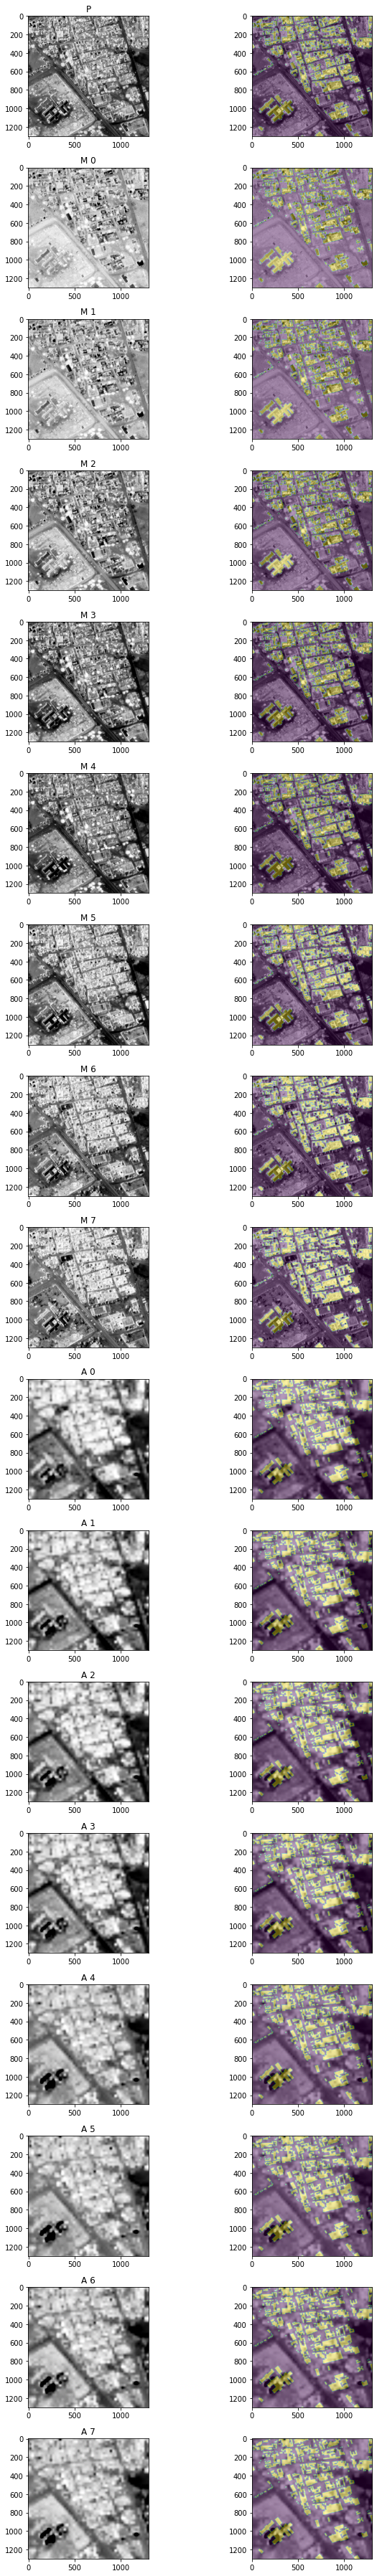

In [ ]:
CLASS_LABELS = ['Buildings', 
                'Misc. Manmade Struct.', 
                'Road',
                'Track', 
                'Trees', 
                'Crops', 
                'Waterway', 
                'Standing Water', 
                'Vehicle Large', 
                'Vehicle Small']

IMAGE_ID = '6120_2_2'
CLASS_TYPE = 1

# See WorldView3 satellite specs at:
# https://satimagingcorp.s3.amazonaws.com/site/pdf/WorldView3-DS-WV3-Web.pdf

# P: Panchromatic bands (record 450-800nm wavelengths in one channel)
print("PANCHROMATIC BANDS:")
p_img = tiff.imread(f'{FP}/sixteen_band/{IMAGE_ID}_P.tif')
p_image_size = p_img.shape
print(f"Shape of single band:\t{p_image_size}")
p_scaled_polygons = get_polygons(wkt_df, IMAGE_ID, CLASS_TYPE, grid_sizes_df, p_image_size)
p_img_mask = mask_for_polygons(p_scaled_polygons, p_image_size)
print(f"Shape of image mask:\t{p_img_mask.shape}")
print()

# M: Multispectral bands (400 - 1040nm wavelengths)
print("MULTISPECTRAL BANDS:")
m_imgs = tiff.imread(f'{FP}/sixteen_band/{IMAGE_ID}_M.tif')
print(f"Shape of M tiff file:\t{m_imgs.shape}")
m_image_size = m_imgs[0].shape
print(f"Shape of single band:\t{m_image_size}")
m_imgs = [resize(m, p_image_size) for m in m_imgs]
print()

# A: SWIR bands (1195 - 2365nm wavelengths)
print("SWIR BANDS:")
a_imgs = tiff.imread(f'{FP}/sixteen_band/{IMAGE_ID}_A.tif')
print(f"Shape of A tiff file: {a_imgs.shape}")
a_image_size = a_imgs[0].shape
print(f"Shape of single band:\t{a_image_size}")
a_imgs = [resize(a, p_image_size) for a in a_imgs]
print()

fig, axes = plt.subplots(17, 2, figsize = (10,50))
normalized_p = normalize_pct(p_img)
axes[0][0].imshow(255 * normalized_p[2000:3300,2000:3300], cmap = "Greys")
axes[0][0].set_title(f"P")
axes[0][1].imshow(255 * normalized_p[2000:3300,2000:3300], cmap = "Greys")

for idx, m in enumerate(m_imgs):
  normalized_m = normalize_pct(m)
  axes[idx+1][0].imshow(255 * normalized_m[2000:3300,2000:3300], cmap = 'Greys')
  axes[idx+1][0].set_title(f"M {idx}")
  axes[idx+1][1].imshow(255 * normalized_m[2000:3300,2000:3300], cmap = 'Greys')

for idx, a in enumerate(a_imgs):
  normalized_a = normalize_pct(a)
  axes[idx+1+len(m_imgs)][0].imshow(255 * normalized_a[2000:3300,2000:3300], cmap = 'Greys')
  axes[idx+1+len(m_imgs)][0].set_title(f"A {idx}")
  axes[idx+1+len(m_imgs)][1].imshow(255 * normalized_a[2000:3300,2000:3300], cmap = 'Greys')

for i in range(17):
  axes[i][1].imshow(255 * p_img_mask[2000:3300,2000:3300], alpha = 0.4)

fig.tight_layout();

Notice that the dimensions of the images are different across bands (very high spatial resolution for panchromatic bands, and lower resolution for multispectral and SWIR bands). Therefore, to utilize all images with the same mask, we must either downsize the panchromatic image to the lowest resolution (SWIR band), or upsize the SWIR band to the highest resolution (Panchromatic band). The latter is preferable (though slightly more computationall intensive) because then we do not lose granularity of the mask (ground truth labels).

# Supervised Modeling: Results and Discussion

We present our results first; the corresponding code and images are in the code cells below.

**Tree detection**

The best-performing model based on Jaccard similarity is the model with multispectral data, achieving a Jaccard similarity of 0.471. The panchromatic model achieves a lower Jaccard of 0.427, while the SWIR model achieves the lowest Jaccard of 0.334. For comparison, the best average (across all 10 classes in the dataset) Jaccard achieved in the original Kaggle competition from which the data is derived was 0.493, indicating that although the results are not strictly comparable (since we only consider tree detection and since the original Kaggle competition was evaluated on an out-of-sample test set not available to us), our model achieves reasonable performance. 

Our results suggest that the multispectral data are particularly useful for tree detection relative to the single-channel panchromatic or multi-channel SWIR data. We hypothesize that this is due to the balance between spatial resolution and depth (spectral resolution) in the multispectral data: the multispectral data are at a lower spatial resolution than the panchromatic data, but at a much higher spatial resolution than the SWIR data. Moreover, since the ground truth labels are provided via polygons defining points in space (which we convert to pixel-level labels using rescaling to fit the size of the input images), using low spatial resolution images necessarily results in more coarse ground truth pixel maps, resulting in a loss of information. We hypothesize that this downsampling of the ground truth is particularly destructive in the case of the low resolution SWIR data, and especially for object classes which are typically small in size such as trees (which is the focus of our analysis).

However, several caveats are necessary that prevent us from presenting definitive conclusions. In the ideal scenario, all modeling parameters should be kept constant (e.g. architecture, patching size, ground truth dimensions, batch size) with the exception of perhaps hyperparameter tuning for each set of input images. In our analysis, for preprocessing simplicity, the input dimension of all Unet models is fixed at 128 x 128, the ground truth mask is scaled to match the dimensions of the input image, and the batch size is therefore defined by the number of 128 x 128 patches extracted from each input image. This results in varying batch size and ground truth dimensions between the different input models (panchromatic, multispectral, SWIR) which limits our ability to conclude that differences in model performance are due specifically to the information content of the input images. Future analysis should consider upsampling the input images (of the SWIR and multispectral images) to match the dimensions of the highest resolution images (the panchromatic images), and using the same mask resolution for all 3 models. This would allow for constant batch size and ground truth resolution across models, making it easier to separate the effect of low resolution inputs from differences in architecture, patching, or data augmentation.

#### **Parameter definitions (supervised modeling base code part 1/3)**

We define global parameters used for training each model (regardless of band type): the amount of validation data, and number of epochs.

In [ ]:
# Learning parameters
VALIDATION_PROP = 0.2     # fraction of data to use for train vs. test, and then also fraction of train to use as validation
EPOCHS = 10

# Get list of all Image IDs (note that these correspond to spatial regions) for which we have ground truth mask labels
IMAGE_ID_LIST = wkt_df.ImageId.unique().tolist()

#### **Preprocessing functions (supervised modeling base code part 2/3)**

We create functions to load the images, scale the ground truth mask appropriately to match the image size, convert each image into patches, and augment each patch. Note that we patch (i.e. take small crops of each image) because the original images are very large for some bands (panchromatic and multispectral), making it infeasible to feed the whole image into a model. Moreover, taking patches and augmenting allows us to have effectively more training examples.

In [ ]:
## Define preprocessing functions...
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def load_images(FP, IMAGE_ID_LIST, BAND_TYPE, CLASS_TYPE, wkt_df, grid_sizes_df, normalize = True):
  images = []; masks = []
  for id in tqdm(IMAGE_ID_LIST):
    img = tiff.imread(f'{FP}/sixteen_band/{id}_{BAND_TYPE}.tif')
    img_size = img.shape[-2:]
    if len(img.shape) == 2:
      images.append(img[..., np.newaxis])
    else:
      images.append(np.rollaxis(img, 0, 3))
    scaled_polygons = get_polygons(wkt_df, id, CLASS_TYPE, grid_sizes_df, img_size)
    img_mask = mask_for_polygons(scaled_polygons, img_size)
    masks.append(img_mask[..., np.newaxis])
  min_x = min([i.shape[0] for i in images])
  min_y = min([i.shape[1] for i in images])
  images = [i[:min_x, :min_y, :].astype('float32') for i in images]
  masks = [m[:min_x, :min_y, :].astype('float32') for m in masks]
  if normalize: # normalize each image channel-wise
    images = [normalize_pct(i) for i in images]
  images = np.stack(images); masks = np.stack(masks)
  print(f"Shape of images:\t{images.shape}")
  print(f"Shape of masks:\t\t{masks.shape}")
  return images, masks

# Augmentation class for segmentation: 
# https://www.tensorflow.org/tutorials/images/segmentation
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed = 42, rotation_factor = 0.5):
    super().__init__()
    self.flip_inputs = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed = seed)
    self.rotate_inputs = tf.keras.layers.RandomRotation(rotation_factor, seed = seed)
    self.flip_labels = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed = seed)
    self.rotate_labels = tf.keras.layers.RandomRotation(rotation_factor, seed = seed)

  def call(self, inputs, labels):
    inputs = self.rotate_inputs(self.flip_inputs(inputs))
    labels = self.rotate_labels(self.flip_labels(labels))
    return inputs, labels

def process_data(fp, image_id_list, band_type, class_type, wkt_df, grid_sizes_df, validation_prop = 0.2):
  print("Loading images...")
  images, masks = load_images(fp, image_id_list, band_type, class_type, wkt_df, grid_sizes_df)

  # Training dataset
  imgs_train, imgs_test, imgs_mask_train, imgs_mask_test = train_test_split(images, masks, 
                                                                          test_size = validation_prop, 
                                                                          random_state = 42)
  imgs_train, imgs_val, imgs_mask_train, imgs_mask_val = train_test_split(imgs_train, imgs_mask_train, 
                                                                          test_size = validation_prop, 
                                                                          random_state = 42)
  train_data = tf.data.Dataset.from_tensor_slices((imgs_train, imgs_mask_train))

  # Validation dataset
  val_data = tf.data.Dataset.from_tensor_slices((imgs_val, imgs_mask_val))

  # Test dataset
  test_data = tf.data.Dataset.from_tensor_slices((imgs_test, imgs_mask_test))

  return train_data, val_data, test_data

# aug_increase is the # of times to increase the data via augmentation
def get_patched_data(train_data, val_data, test_data, n_input_channels = 8, buffer_size = 1000, aug_increase = 8):
  # Creating patches from images:
  # Modified from: https://stackoverflow.com/questions/64326029/load-tensorflow-images-and-create-patches
  get_patches = lambda x, y: (tf.reshape(tf.image.extract_patches(
        images=tf.expand_dims(x, 0),
        sizes=[1, 128, 128, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'), 
        (-1, 128, 128, n_input_channels)),
    tf.reshape(tf.image.extract_patches(
        images=tf.expand_dims(y, 0),
        sizes=[1, 128, 128, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'),
        (-1, 128, 128, 1)))
  train_data_patched = (
    train_data
    .map(get_patches)
    .shuffle(buffer_size)
    .cache()
    .repeat(aug_increase) # repeat before augment?
    .map(Augment(), num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
  )
  val_data_patched = (
      val_data
      .map(get_patches)
  )
  test_data_patched = (
      test_data
      .map(get_patches)
  )
  return train_data_patched, val_data_patched, test_data_patched

#### **Modeling functions (supervised modeling base code part 3/3)**

In this last section of the supervised modeling code, we introduce DICE + BC loss, our model architecture (UNet with pretrained MobileNetV2 encoder), visualization helper functions, and evaluation metric (Jaccard similarity).

In [ ]:
# Dice loss with cross entropy:
# https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
def dice_bc_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
      numerator = 2 * tf.reduce_sum(y_true * y_pred)
      denominator = tf.reduce_sum(y_true + y_pred)

      return 1 - numerator / denominator

    #y_true = tf.cast(y_true, tf.float32)
    o = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

# Define the model type:
def build_model(n_input_channels = 8):
  # unet with pretrained mobilenetv2 encoder 
  # ATTRIBUTION: https://www.tensorflow.org/tutorials/images/segmentation#define_the_model
  # modified to accept arbitrary n_channels via addition of a 2D conv layer
  # define encoder:
  base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False)
  layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
  ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
  down_stack.trainable = False

  # define decoder:
  up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
  ]

  def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=(128, 128, n_input_channels))

     # convert 8 channel to 3 channel:
    dense_filter = tf.keras.layers.Conv2D(3, n_input_channels, padding='same')(inputs) #####

    # downsample
    # skips = down_stack(inputs)
    skips = down_stack(dense_filter) ####
    x = skips[-1]
    skips = reversed(skips[:-1])

    # upsample w/ skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x)
      concat = tf.keras.layers.Concatenate()
      x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = tf.keras.activations.sigmoid(last(x)) # apply sigmoid
    return tf.keras.Model(inputs=inputs, outputs=x)

  model = unet_model(output_channels=1)
  return model

def model_train(model,train_data, val_data, loss_function = 'dice_bc', learning_rate = 0.001):
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
                loss = dice_bc_loss if loss_function == 'dice_bc' else 'binary_crossentropy',
                metrics = ['accuracy'])

  print('*'*30)
  print('Fitting model...')
  print('*'*30)
  history =  model.fit(train_data, 
                      epochs = EPOCHS,
                      validation_data = val_data,
                      verbose=1)
  return history

# Visualize model predictions
# num_images: how many images to show
# _band_for_viz: which band to show (for overlay)
def viz_predictions(test_imgs, test_masks, test_pred, class_type, band_type, num_images = 5, _band_for_viz = 7):
  truth_color = matplotlib.colors.ListedColormap(['none', 'blue'])
  pred_color = matplotlib.colors.ListedColormap(['none', 'red'])
  fig, axes = plt.subplots(2, num_images, figsize = (13,5))
  fig.subplots_adjust(top=0.85)

  for i in range(num_images):
    axes[0][i].imshow(test_imgs[i][:,:,_band_for_viz].squeeze(), cmap = 'Greys')
    axes[0][i].xaxis.set_ticks([]); axes[0][i].yaxis.set_ticks([])
    axes[1][i].imshow(test_masks[i].squeeze(), cmap = truth_color, alpha = 0.5)
    axes[1][i].imshow(test_pred[i].squeeze(), cmap = pred_color, alpha = 0.5)
    axes[1][i].xaxis.set_ticks([]); axes[1][i].yaxis.set_ticks([])

  # Adding legend to imshow:
  # https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
  patches = [mpatches.Patch(color=['blue', 'red'][i], 
                            label=f"{[f'true {CLASS_LABELS[class_type-1]}', f'predicted {CLASS_LABELS[class_type-1]}'][i]}")for i in range(2) ]
  fig.legend(handles=patches, loc = (0.7, 0.88), ncol = 2);
  fig.suptitle(f"{num_images} Test Set Predictions ({band_type} model)", y = 0.98);

def get_pixel_jaccard(pred, truth):
  # Get pixel-level Jaccard
  # based on https://www.kaggle.com/code/lopuhin/full-pipeline-demo-poly-pixels-ml-poly/notebook
  tp, fp, fn = (( (pred==1) &  (truth==1)).sum(),
                ( (pred==1) & ~(truth==1)).sum(),
                (~(pred==1) &  (truth==1)).sum())
  jc = tp / (tp + fp + fn)
  print('Pixel jaccard:', jc)
  return jc

#### **MULTISPECTRAL MODEL**

We first consider a UNet model which accepts only the multispectral band images: each input is therefore 8 layers deep. Recall that we only consider tree prediction (class #5). The 25 images available for this class are (837 x 835), and therefore the dimension of the input is (25, 837, 835, 8). After patching the images (taking crops of size 128 x 128), each image becomes of shape (128, 128, 8). 

In [ ]:
BAND_TYPE = 'M'
CLASS_TYPE = 5
N_INPUT_CHANNELS = 8

# Load images
train_data, val_data, test_data = process_data(FP, IMAGE_ID_LIST, BAND_TYPE, CLASS_TYPE, wkt_df, grid_sizes_df, VALIDATION_PROP)
print(f"Number of images in train data: {len(train_data)}")
print(f"Number of images in val data: {len(val_data)}")
print(f"Number of images in test data: {len(test_data)}")

# Convert images to patches
train_patched, val_patched, test_patched = get_patched_data(train_data, val_data, test_data, 
                                                            n_input_channels = N_INPUT_CHANNELS, 
                                                            buffer_size = 36 * len(train_data), 
                                                            aug_increase = 5)
print(f"Shape of single example after patching: {next(iter(train_patched))[0].shape}")

Loading images...


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Shape of images:	(25, 837, 835, 8)
Shape of masks:		(25, 837, 835, 1)
Number of images in train data: 16
Number of images in val data: 4
Number of images in test data: 5
Shape of single example after patching: (36, 128, 128, 8)


For sense-checking to make sure that our patching function works as expected, below we show an original image, and then the patched image. We see that the patching indeed works as expected, taking the top left 128 x 128 pixels of the original image.

Shape of patched image: (36, 128, 128, 8)


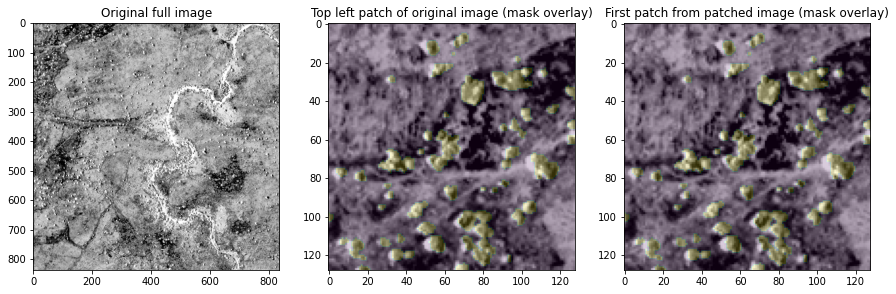

In [ ]:
### (This cell is for sense-checking only, to verify that patching indeed works as expected):

# Patching function
get_patches = lambda x, y: (tf.reshape(tf.image.extract_patches(
      images=tf.expand_dims(x, 0),
      sizes=[1, 128, 128, 1],
      strides=[1, 128, 128, 1],
      rates=[1, 1, 1, 1],
      padding='VALID'), 
      (-1, 128, 128, 8)),
  tf.reshape(tf.image.extract_patches(
      images=tf.expand_dims(y, 0),
      sizes=[1, 128, 128, 1],
      strides=[1, 128, 128, 1],
      rates=[1, 1, 1, 1],
      padding='VALID'),
      (-1, 128, 128, 1)))

# Comparing patches vs. crops to verify that patching indeed works as expected:
fig, axes = plt.subplots(1, 3, figsize = (15,5))
_band_for_viz = 7
_fullimg, _fullmask = next(iter(train_data))
axes[0].imshow(_fullimg[:, :, _band_for_viz], cmap = 'Greys')
axes[0].set_title("Original full image")

axes[1].imshow(_fullimg[:128, :128, _band_for_viz], cmap = 'Greys')
axes[1].imshow(_fullmask[:128, :128, 0], alpha = 0.2)
axes[1].set_title("Top left patch of original image (mask overlay)")

_patchimg, _patchmask = next(iter(train_data.map(get_patches)))
print(f"Shape of patched image: {_patchimg.shape}")
axes[2].imshow(_patchimg[0][:, :, _band_for_viz], cmap = 'Greys')
axes[2].imshow(_patchmask[0][:, :, 0], alpha = 0.2)
axes[2].set_title("First patch from patched image (mask overlay)");

Below we validate that patching + augmentation works as expected. We see that indeed the augmentation is applying rotations randomly to each patch.

Shape of single example after patching: (36, 128, 128, 8)


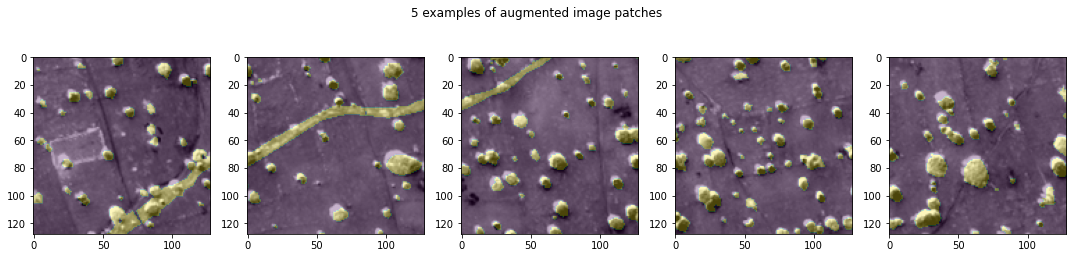

In [ ]:
### (This cell is for sense-checking only, to verify that patching + augmentation indeed works as expected):
n_patches_to_show = 5
fig, axes = plt.subplots(1, n_patches_to_show, figsize = (15,4))
_patchimg, _patchmask = next(iter(train_patched))
print(f"Shape of single example after patching: {_patchimg.shape}")

for p in range(n_patches_to_show):
  axes[p].imshow(_patchimg[p][:, :, _band_for_viz], cmap = 'Greys')
  axes[p].imshow(_patchmask[p][:, :, 0], alpha = 0.3)
fig.suptitle(f"{n_patches_to_show} examples of augmented image patches")
fig.tight_layout();

In [ ]:
model = build_model(n_input_channels = N_INPUT_CHANNELS)
model_history = model_train(model, train_patched, val_patched, learning_rate = 0.003)

******************************
Fitting model...
******************************
Epoch 1/10
80/80 [==============================] - 11s 91ms/step - loss: 0.8650 - accuracy: 0.8761 - val_loss: 3.1775 - val_accuracy: 0.4383
Epoch 2/10
80/80 [==============================] - 6s 80ms/step - loss: 0.6895 - accuracy: 0.9042 - val_loss: 1.2115 - val_accuracy: 0.7846
Epoch 3/10
80/80 [==============================] - 6s 80ms/step - loss: 0.6507 - accuracy: 0.9095 - val_loss: 0.6443 - val_accuracy: 0.9272
Epoch 4/10
80/80 [==============================] - 6s 79ms/step - loss: 0.6055 - accuracy: 0.9172 - val_loss: 0.6491 - val_accuracy: 0.9331
Epoch 5/10
80/80 [==============================] - 6s 79ms/step - loss: 0.5916 - accuracy: 0.9192 - val_loss: 0.6557 - val_accuracy: 0.9334
Epoch 6/10
80/80 [==============================] - 6s 79ms/step - loss: 0.5681 - accuracy: 0.9230 - val_loss: 0.7454 - val_accuracy: 0.9305
Epoch 7/10
80/80 [==============================] - 6s 79ms/step - loss: 0

In [ ]:
test_pred = model.predict(test_patched)
# convert predictions to binary values based on probability > threshold
pred_threshold = 0.2
test_pred = test_pred >= pred_threshold
test_masks = np.concatenate([y for x, y in test_patched], axis=0)
test_imgs = np.concatenate([x for x, y in test_patched], axis=0)
print(test_masks.shape)
print(test_imgs.shape)

(180, 128, 128, 1)
(180, 128, 128, 8)


Below we see that the multispectral image model achieves reasonable performance in predicting tree location: there is lots of overlap between the blue (ground truth mask) and red (predicted mask). Moreover, even where our model 'makes mistakes' relative to the ground truth mask, we see that these 'mistakes' are reasonable when referring to the original image (top row in the below). For example, in the middle image, only a portion of the bottom left is predicted as trees, whereas the ground truth labels marks the entire bottom left corner as trees; however, referring to the original image, part of this region appears to be shadows rather than trees, so in a sense, our predictions seem to be 'more' correct.

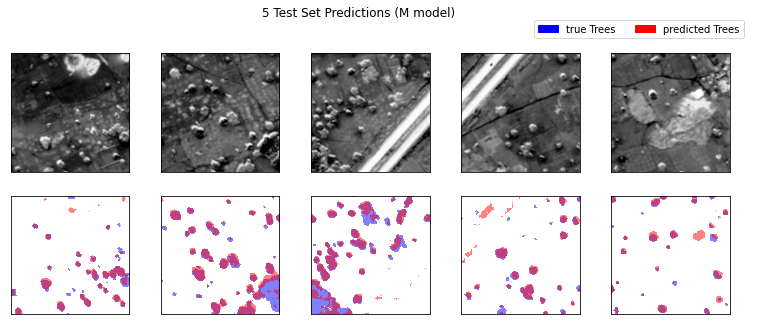

In [ ]:
viz_predictions(test_imgs, test_masks, test_pred, class_type = CLASS_TYPE, band_type = BAND_TYPE, num_images = 5, _band_for_viz = 7);

In [ ]:
jc = get_pixel_jaccard(test_pred, test_masks)

Pixel jaccard: 0.471439610923631


In [ ]:
print(len(train_data))
print(len(train_patched)) # this is (# times augment) x (len(train_data))

16
80


#### **SWIR MODEL**

We now consider a UNet model which accepts only the SWIR band images: each input is therefore 8 layers deep. Recall that we only consider tree prediction (class #5). The 25 images available for this class are (133 x 134), and therefore the dimension of the input is (25, 133, 134, 8). After patching the images (taking crops of size 128 x 128), each image becomes of shape (128, 128, 8). 

In [ ]:
BAND_TYPE = 'A'
CLASS_TYPE = 5
N_INPUT_CHANNELS = 8

# Load images
train_data, val_data, test_data = process_data(FP, IMAGE_ID_LIST, BAND_TYPE, CLASS_TYPE, wkt_df, grid_sizes_df, VALIDATION_PROP)
print(f"Number of images in train data: {len(train_data)}")
print(f"Number of images in val data: {len(val_data)}")
print(f"Number of images in test data: {len(test_data)}")

# Convert images to patches
train_patched, val_patched, test_patched = get_patched_data(train_data, val_data, test_data, 
                                                            n_input_channels = N_INPUT_CHANNELS, 
                                                            buffer_size = 36 * len(train_data), 
                                                            aug_increase = 10)

print(f"Shape of single example after patching: {next(iter(train_patched))[0].shape}")

Loading images...


100%|██████████| 25/25 [00:08<00:00,  3.09it/s]


Shape of images:	(25, 133, 134, 8)
Shape of masks:		(25, 133, 134, 1)
Number of images in train data: 16
Number of images in val data: 4
Number of images in test data: 5
Shape of single example after patching: (1, 128, 128, 8)


In [ ]:
model = build_model(n_input_channels = N_INPUT_CHANNELS)
model_history = model_train(model, train_patched, val_patched, learning_rate = 0.001)

******************************
Fitting model...
******************************
Epoch 1/10
160/160 [==============================] - 6s 20ms/step - loss: 1.2249 - accuracy: 0.6446 - val_loss: 1.1952 - val_accuracy: 0.6692
Epoch 2/10
160/160 [==============================] - 2s 15ms/step - loss: 1.0224 - accuracy: 0.7374 - val_loss: 1.1559 - val_accuracy: 0.6931
Epoch 3/10
160/160 [==============================] - 2s 15ms/step - loss: 0.8457 - accuracy: 0.7985 - val_loss: 1.1531 - val_accuracy: 0.7133
Epoch 4/10
160/160 [==============================] - 2s 15ms/step - loss: 0.6558 - accuracy: 0.8527 - val_loss: 1.1729 - val_accuracy: 0.7070
Epoch 5/10
160/160 [==============================] - 2s 15ms/step - loss: 0.5012 - accuracy: 0.8918 - val_loss: 1.2080 - val_accuracy: 0.7025
Epoch 6/10
160/160 [==============================] - 2s 15ms/step - loss: 0.3844 - accuracy: 0.9197 - val_loss: 1.2304 - val_accuracy: 0.7237
Epoch 7/10
160/160 [==============================] - 2s 15ms/s

Below we see that the SWIR image model achieves poor performance in predicting tree location: there is relatively little overlap between the blue (ground truth mask) and red (predicted mask). Also note that the image and mask appear to be 'dotted'/speckled: this is likely because the SWIR images are low resolution (133, 134) and covering a large spatial area (1km x 1km), and therefore small objects like trees would have a very coarse mask (a single pixel covers a very large spatial area). Intuitively, we'd expect poor performance here because trees are very small relative to the spatial area covered by each image (1km x 1km), and indeed the Jaccard similarity is low (0.33).

(5, 128, 128, 1)
(5, 128, 128, 8)


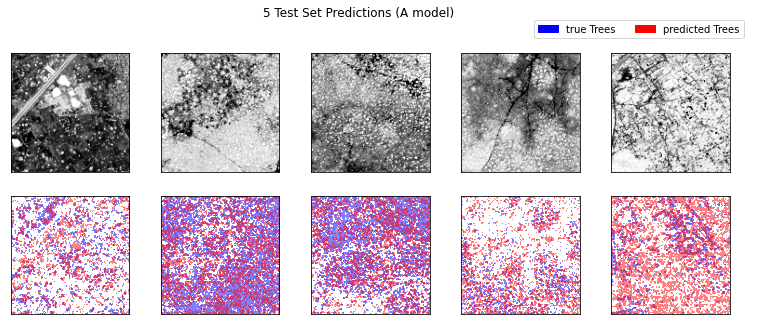

In [ ]:
test_pred = model.predict(test_patched)
# convert predictions to binary values based on probability > threshold
pred_threshold = 0.2
test_pred = test_pred >= pred_threshold
test_masks = np.concatenate([y for x, y in test_patched], axis=0)
test_imgs = np.concatenate([x for x, y in test_patched], axis=0)
print(test_masks.shape)
print(test_imgs.shape)

viz_predictions(test_imgs, test_masks, test_pred, class_type = CLASS_TYPE, band_type = BAND_TYPE, num_images = 5, _band_for_viz = 7);

In [ ]:
jc = get_pixel_jaccard(test_pred, test_masks)

Pixel jaccard: 0.3336254151977666


In [ ]:
print(len(train_data))
print(len(train_patched)) # this is (# times augment) x (len(train_data))

16
160


#### **PANCHROMATIC MODEL**

Lastly we consider a UNet model which accepts only the panchromatic image: each input is therefore 1 layer deep. Recall that we only consider tree prediction (class #5). The 25 images available for this class are (3348 x 3338), and therefore the dimension of the input is (25, 3348, 3338, 8). After patching the images (taking crops of size 128 x 128), each image becomes of shape (128, 128, 1). In the example images shown below, we can see just how high resolution each patch is: trees occupy a very large portion (in terms of fraction of pixels) of each patch fed into the model. This is a big contrast to the SWIR inputs, in which a single patch covered a very large spatial area (nearly 1km x 1km).

In [ ]:
BAND_TYPE = 'P'
CLASS_TYPE = 5
N_INPUT_CHANNELS = 1

# Load images
train_data, val_data, test_data = process_data(FP, IMAGE_ID_LIST, BAND_TYPE, CLASS_TYPE, wkt_df, grid_sizes_df, VALIDATION_PROP)
print(f"Number of images in train data: {len(train_data)}")
print(f"Number of images in val data: {len(val_data)}")
print(f"Number of images in test data: {len(test_data)}")

# Convert images to patches
train_patched, val_patched, test_patched = get_patched_data(train_data, val_data, test_data, 
                                                            n_input_channels = N_INPUT_CHANNELS, 
                                                            buffer_size = 36 * len(train_data), 
                                                            aug_increase = 1)

print(f"Shape of single example after patching: {next(iter(train_patched))[0].shape}")

Loading images...


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Shape of images:	(25, 3348, 3338, 1)
Shape of masks:		(25, 3348, 3338, 1)
Number of images in train data: 16
Number of images in val data: 4
Number of images in test data: 5
Shape of single example after patching: (676, 128, 128, 1)


Shape of single example after patching: (676, 128, 128, 1)


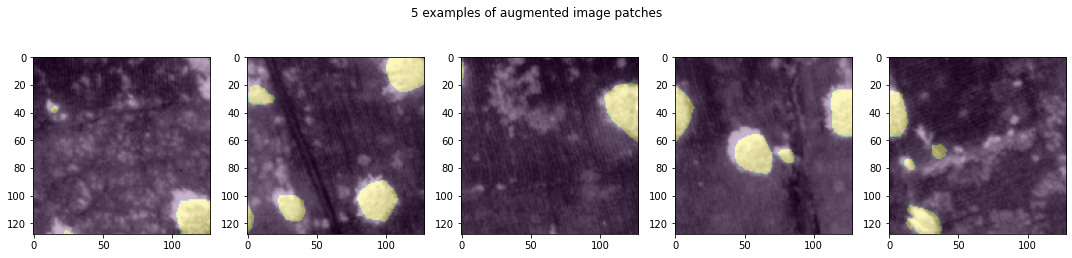

In [ ]:
### (This cell is for sense-checking only, to verify that patching + augmentation indeed works as expected):
n_patches_to_show = 5
fig, axes = plt.subplots(1, n_patches_to_show, figsize = (15,4))
_patchimg, _patchmask = next(iter(train_patched))
print(f"Shape of single example after patching: {_patchimg.shape}")

for p in range(n_patches_to_show):
  axes[p].imshow(_patchimg[p][:, :, 0], cmap = 'Greys')
  axes[p].imshow(_patchmask[p][:, :, 0], alpha = 0.3)
fig.suptitle(f"{n_patches_to_show} examples of augmented image patches")
fig.tight_layout();

In [ ]:
model = build_model(n_input_channels = N_INPUT_CHANNELS)

# since the images are too large, we have to unbatch each set of patches, and rebatch into 64 (i.e. accept 64 patches at a time)
model_history = model_train(model, 
                            train_patched.unbatch().batch(64), 
                            val_patched.unbatch().batch(64), 
                            learning_rate = 0.001)

******************************
Fitting model...
******************************
Epoch 1/10
169/169 [==============================] - 27s 133ms/step - loss: 0.9687 - accuracy: 0.8856 - val_loss: 0.7429 - val_accuracy: 0.9198
Epoch 2/10
169/169 [==============================] - 21s 127ms/step - loss: 0.8306 - accuracy: 0.9001 - val_loss: 0.7277 - val_accuracy: 0.9364
Epoch 3/10
169/169 [==============================] - 21s 127ms/step - loss: 0.8217 - accuracy: 0.9002 - val_loss: 0.7100 - val_accuracy: 0.9354
Epoch 4/10
169/169 [==============================] - 21s 127ms/step - loss: 0.8164 - accuracy: 0.9008 - val_loss: 0.7272 - val_accuracy: 0.9370
Epoch 5/10
169/169 [==============================] - 21s 127ms/step - loss: 0.8091 - accuracy: 0.9018 - val_loss: 0.7114 - val_accuracy: 0.9362
Epoch 6/10
169/169 [==============================] - 21s 126ms/step - loss: 0.8007 - accuracy: 0.9030 - val_loss: 0.7034 - val_accuracy: 0.9346
Epoch 7/10
169/169 [==============================]

Below we see that the panchromatic image model achieves reasonable performance in predicting tree location: there is noticeable overlap between the blue (ground truth mask) and red (predicted mask). Moreover, even where our model 'makes mistakes' relative to the ground truth mask, we see that these 'mistakes' are reasonable when referring to the original image (top row in the below). In particular, many of the original images (such as the third from the left) appear to have objects which are difficult to identify even to the human eye (it is somewhat unclear which objects in the black and white images correspond to trees, particularly when the contours of the objects appear blurred). The Jaccard similarity achieved is reasonably good (0.427).

(3380, 128, 128, 1)
(3380, 128, 128, 1)


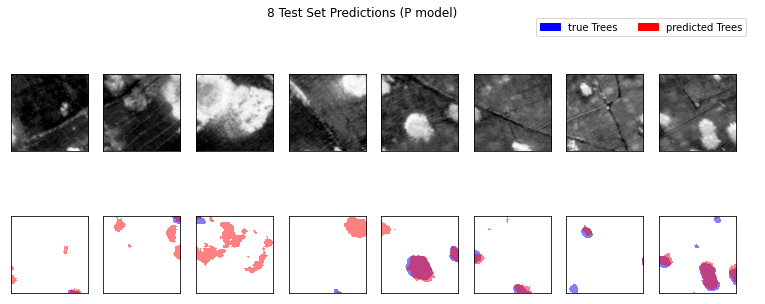

In [ ]:
test_pred = model.predict(test_patched)
# convert predictions to binary values based on probability > threshold
pred_threshold = 0.2
test_pred = test_pred >= pred_threshold
test_masks = np.concatenate([y for x, y in test_patched], axis=0)
test_imgs = np.concatenate([x for x, y in test_patched], axis=0)
print(test_masks.shape)
print(test_imgs.shape)

viz_predictions(test_imgs, test_masks, test_pred, class_type = CLASS_TYPE, band_type = BAND_TYPE, num_images = 8, _band_for_viz = 0);

In [ ]:
jc = get_pixel_jaccard(test_pred, test_masks)

Pixel jaccard: 0.42714259590271914


## Unsupervised Methods: Results and Discussion

Using pixel-level 17-dimensional vectors (the image information corresponding to the ground truth label masks) results in a total of 115,474 vectors; we see that there is no clear clustering of the vectors based on classes. We observe that mass centers (density of scatter) for various classes are relatively distinct, but the data points from each class have higher overlap with other classes and are hence not clearly separated. However, when we use the averaging method (averaging the vectors for each class for each image), we see some clustering patterns. For example, track, trees, and standing water appear to form their own clusters. However, one caveat is that the averaging method might not be a truthful representation of all the relevant pixels, since it simply takes an average of all pixels in the image that correspond to a certain class. 
Compared with resizing to 128 x 128, resizing to 768 x 768 yields more noticeable visual clusters. This aligns with our hypothesis that more granular spatial information is useful for the classification task under unsupervised methods as well. 

For the TSNE method, the time needed for fitting the model is significantly longer. We experimented with visualization using various levels of perplexity (from around 5 to around 50). TSNE also does not yield obvious class clusters, regardless of perplexity level, if considering pixel-level vectors. However, when considering the averaged vectors (for each class for each image), there are more obvious clusters between certain classes (Building, Trees, Waterway).

In [ ]:
from shapely.geos import L
from skimage.transform import rescale, resize
# function to get a stacked 17x1 vector representing a specific class of a specific image (if average = True)
# if average = False, return vectors corresponding to all relevant pixels
def get_stacked_avg(img_id, class_id, dim, visualize = False, average = True):
  p_img = normalize_pct(tiff.imread(f'{FP}/sixteen_band/{img_id}_P.tif'))
  p_img = resize(p_img,(dim,dim))
  
  p_image_size = p_img.shape
  #print(f"Shape of single band:\t{p_image_size}")
  p_scaled_polygons = get_polygons(wkt_df, img_id, class_id, grid_sizes_df, p_image_size)
  p_img_mask = mask_for_polygons(p_scaled_polygons, p_image_size)
  mask_max = p_img_mask.max()
  #print(p_img_mask)
  if visualize:
    truth_color = matplotlib.colors.ListedColormap(['none', 'red'])
    plt.imshow(p_img, cmap = 'gray')
    plt.imshow(p_img_mask, cmap = truth_color, alpha = 0.5)

  plst = []

  # M: Multispectral bands (400 - 1040nm wavelengths)
  m_imgs = tiff.imread(f'{FP}/sixteen_band/{img_id}_M.tif')
  m_image_size = (dim,dim)
  m_imgs = [resize(m, m_image_size) for m in m_imgs]
  normalized_m = []
  for idx, m in enumerate(m_imgs):
    normalized_m.append(normalize_pct(m))
  m_img_normalized = np.stack(normalized_m) # 8 x 128 x 128
  #print(m_img_normalized )
  # plt.imshow(m_imgs[0], cmap = 'gray')
  # plt.imshow(p_img_mask, alpha = 0.5)
  mlst = []

  # SWIR bands image normalization
  a_imgs = tiff.imread(f'{FP}/sixteen_band/{img_id}_A.tif')
  a_image_size = (dim,dim)
  a_imgs = [resize(a, a_image_size) for a in a_imgs]
  normalized_a = []
  for idx, a in enumerate(a_imgs):
    normalized_a.append(normalize_pct(a))
  a_img_normalized = np.stack(normalized_a) # 8 x 128 x 128
  #print(a_img_normalized )
  # plt.imshow(a_imgs[0], cmap = 'gray')
  # plt.imshow(p_img_mask, alpha = 0.5)

  alst = []

  pixel_indices = np.transpose(np.nonzero(p_img_mask))
  for coord in pixel_indices:
    a, b = coord
    plst.append(p_img[a,b])
    alst.append(a_img_normalized[:,a,b])
    mlst.append(m_img_normalized[:,a,b])
  plst = np.asarray(plst).reshape((-1,1))
  alst = np.asarray(alst)
  mlst = np.asarray(mlst)
  #print(img_id, class_id, "with mlst",mlst)

  l = len(plst)
  if l > 0:
    if average:
      p_mean = np.mean(plst)
      m_mean = np.mean(mlst, axis = 0)
      a_mean = np.mean(alst, axis = 0)
      return np.hstack((p_mean, m_mean, a_mean)), 1 # l indicates class label will be added once 
    else:
      rand_indices = np.arange(l)
      np.random.shuffle(rand_indices)
      rand_indices = rand_indices[:1000]
      #print(plst[rand_indices].shape, alst[rand_indices, :].shape, mlst[rand_indices,:].shape)
      result = np.hstack((plst[rand_indices], alst[rand_indices, :], mlst[rand_indices,:]))
      #print(result.shape)
      return result, len(rand_indices) #class label will be added len(rand_indices) times
  else:
    return np.asarray([]),0 


(array([[0.12019355, 0.4021081 , 0.31278565, ..., 0.04701863, 0.05897079,
         0.01775941],
        [0.61167004, 0.36497952, 0.38955263, ..., 0.6603743 , 0.59739858,
         0.48924991],
        [0.54234312, 1.        , 1.        , ..., 0.20486147, 0.64108711,
         0.64475596],
        ...,
        [0.82133158, 0.42863209, 0.5353887 , ..., 1.        , 0.9309481 ,
         0.93101275],
        [0.70603699, 0.17136077, 0.26892648, ..., 0.85878914, 0.760548  ,
         0.72211756],
        [0.71152498, 0.48460805, 0.14667694, ..., 0.51190081, 0.54761515,
         0.53293987]]), 1000)

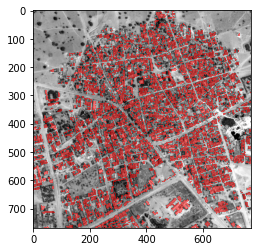

In [ ]:
# example
get_stacked_avg('6120_2_2', 1, 768, True, False) # works
#get_stacked_avg('6140_2_2', 1,768, True) # note that some class might not exist in picture

In [ ]:
# number of non-empty masks
len(wkt_df)

250

In [ ]:
vector_data_768_NoAvg = []
vector_label_768_NoAvg = []
for row in range(len(wkt_df)):
  if row % 10 == 0:
    print(f"Processing row {row}") 
  imageid = wkt_df["ImageId"][row]
  classid = wkt_df["ClassType"][row]
  stacked, label_copies = get_stacked_avg(imageid, classid, 768, False, False)
  vector_data_768_NoAvg.append(stacked)
  for i in range(label_copies):
    vector_label_768_NoAvg.append(classid)

import pickle
with open('./vector_data_768_NoAvg.pkl', 'wb') as f:
  pickle.dump(vector_data_768_NoAvg, f)
with open('./vector_label_768_NoAvg.pkl', 'wb') as f:
  pickle.dump(vector_label_768_NoAvg, f)

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210
Processing row 220
Processing row 230
Processing row 240


In [ ]:
# PCA 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# process vectors to be ready for decomposition
def preprocess_vectors(vdata, vlabel):
  vdata = [vd for vd in vdata if len(vd) != 0]
  vdata = np.vstack(vdata)
  vlabel = np.asarray(vlabel)
  print(vdata.shape ,vlabel.shape)
  return vdata, vlabel

# helper functions to reduce dimension and visualize 
def get_decomposition(v_data, v_label,  n = 2,  w = True, type = "PCA", perplexity = 5):
  if type == "PCA":
    decomp = PCA(n_components=n, whiten=w)
  else:
    decomp = TSNE(n_components=n, perplexity = perplexity)
  # Separate the vectors into labels
  inds=np.array([v_label==i+1 for i in range(10)])
  # print(inds)
  #decomp.fit(v_data)
  sk_reduced=decomp.fit_transform(v_data)
  return sk_reduced, inds
  
def plot_decomposition(reduced, inds, filename, s = 3, classes = np.arange(10), savefig = True):
  # print(sk_reduced.shape)
  plt.figure(figsize=(10,10))
  for i in classes:
    plt.scatter(reduced[inds[i],0],
              reduced[inds[i],1],  cmap = 'grey', label=CLASS_LABELS[i], alpha=0.7, s = s)
  plt.gca().legend()
  plt.title(filename)
  if savefig:
    plt.savefig(filename)
  plt.show()

#### PCA for all vectors (not average method)

Each point in the scatter below represents a pixel corresponding to a class: since for each image, we stack all band information available, each image is 17 layers deep (channels), and so each pixel corresponding to a class is a vector of length 17. We perform PCA on these 'spectral profiles' and show the projection along the first 2 components below. 

(115474, 17) (115474,)


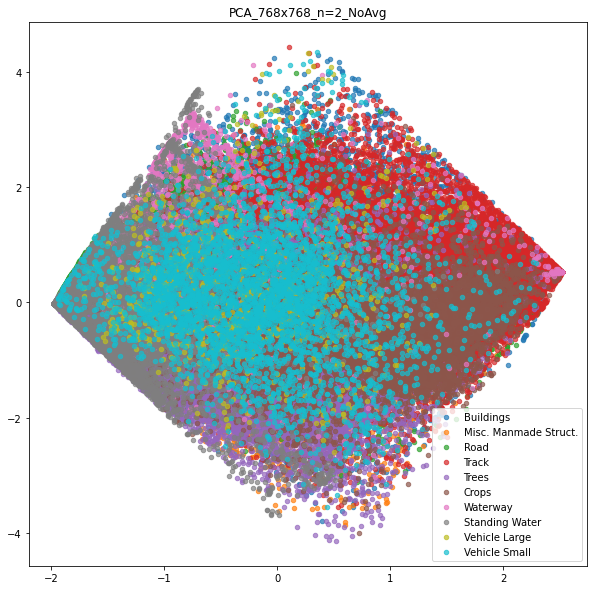

In [ ]:
vector_data_768_NoAvg, vector_label_768_NoAvg = preprocess_vectors(vector_data_768_NoAvg, vector_label_768_NoAvg)
a1, a2 = get_decomposition(vector_data_768_NoAvg, vector_label_768_NoAvg, n = 2, type = 'PCA')
plot_decomposition(a1, a2,"PCA_768x768_n=2_NoAvg", s = 20, classes = np.arange(10), savefig = True)

For ease of visualization, we only show a subset of classes in the below:

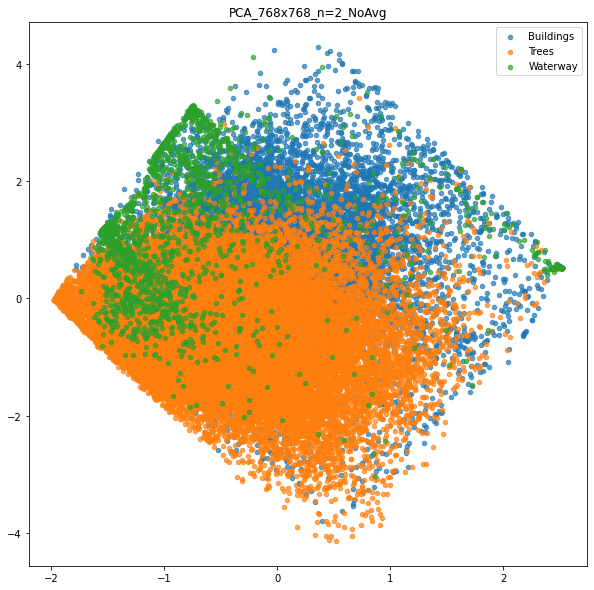

In [ ]:
plot_decomposition(a1, a2,"PCA_768x768_n=2_NoAvg", s = 20, classes = [0,4,6], savefig = False)

#### PCA for average vectors

Rather than plotting each pixel corresponding to each class, we now consider taking the average of the pixel vectors for each class for each image to obtain a 'representative' spectral profile per class per image. We visualize this again with PCA in the below:

In [ ]:
import pickle

# load pickle files
with open('vector_data_768_avg.pkl', 'rb') as f:
    vector_data_768_avg = pickle.load(f)
with open('vector_label_768_avg.pkl', 'rb') as f:
    vector_label_768_avg = pickle.load(f)
with open('tsne_vector_data.pkl', 'rb') as f: # in fact the processed and decomposed t1 for tsne (wrong naming)
    t1 = pickle.load(f)
with open('tsne_vector_label.pkl', 'rb') as f: # in fact the processed and decomposed t2 for tsne (wrong naming)
    t2 = pickle.load(f)

(138, 17) (138,)


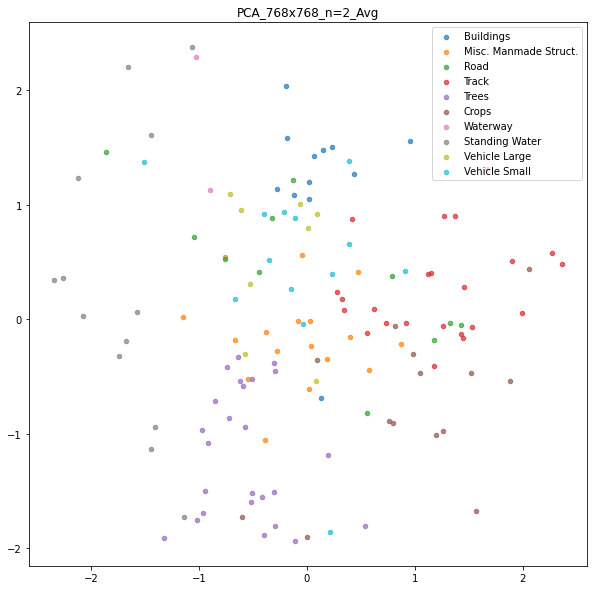

In [ ]:
vector_data_768_avg, vector_label_768_avg = preprocess_vectors(vector_data_768_avg, vector_label_768_avg)
a1, a2 = get_decomposition(vector_data_768_avg, vector_label_768_avg,  n = 2,  w = True, type = "PCA")
plot_decomposition(a1, a2,"PCA_768x768_n=2_Avg", s = 20, classes = np.arange(10), savefig = True)

#### TSNE for all vectors (non-average)

As a reminder, 'non average' refers to: each point in the scatter below represents a pixel labeled to a certain class. The 17-dimensional pixel vectors are reduced to 2 dimensions using TSNE.

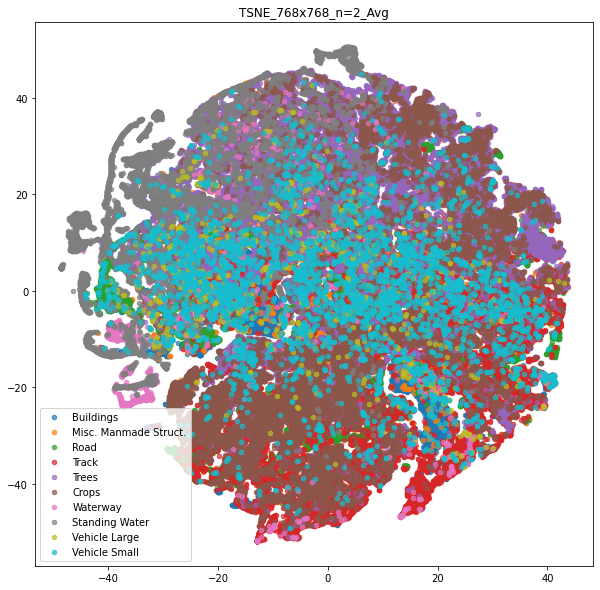

In [ ]:
plot_decomposition(t1, t2,"TSNE_768x768_n=2_Avg", s = 20, classes = np.arange(10), savefig = True)

Below we show the same visual, but showing only a subset of classes:

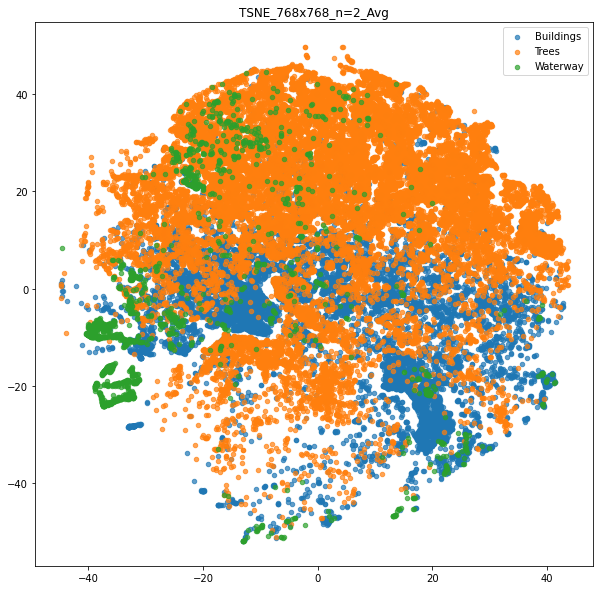

In [ ]:
plot_decomposition(tsne_vector_data, tsne_vector_label,"TSNE_768x768_n=2_Avg", s = 20, classes = [0,4,6], savefig = True)

#### TSNE for average vectors

Each point in the scatter below represents the averaged 17-dimensional pixels for each image (for each class). 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


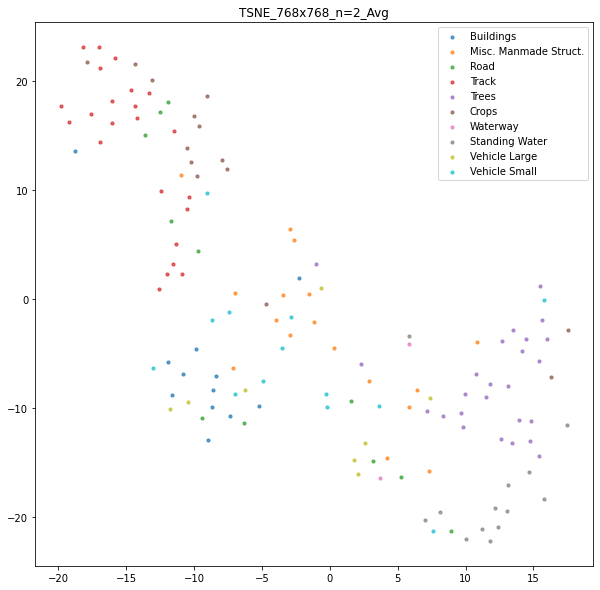

In [ ]:
# for average vectors
t1_avg, t2_avg = get_decomposition(vector_data_768_avg, vector_label_768_avg, n = 2, type = 'TSNE', perplexity = 15)
plot_decomposition(t1_avg, t2_avg,"TSNE_768x768_n=2_Avg", s = 10, classes = np.arange(10), savefig = True)

The same plot, but showing only a subset of classes:

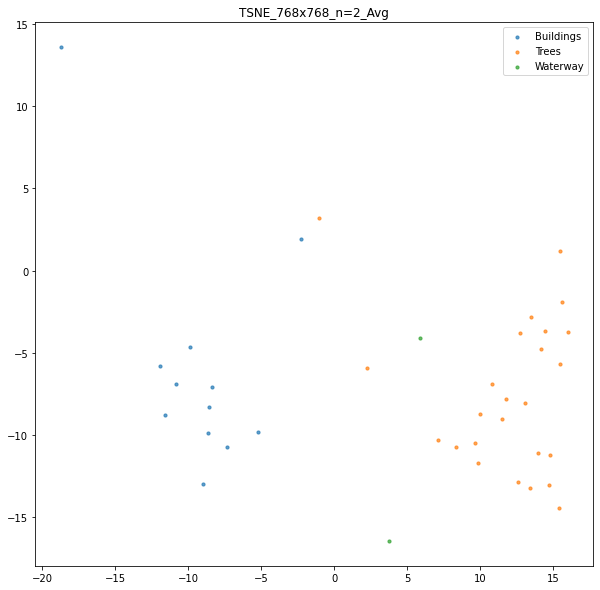

In [ ]:
plot_decomposition(t1_avg, t2_avg,"TSNE_768x768_n=2_Avg", s = 10, classes = [0,4,6], savefig = True)

## Conclusion

With respect to the supervised portion of our analysis, our main result is an applied finding (rather than a theoretical conclusion): despite the high dimensionality of inputs and the relatively few ground truth labels, we obtain reasonable image segmentation performance for tree detection (0.471 Jaccard similarity) by applying a Unet model with transfer learning to multispectral image inputs. Models we trained based on panchromatic or SWIR inputs achieved lower Jaccard similarity (0.427, 0.334 respectively), though it is inconclusive whether these are due to limitations in the inputs, or in differences in model training and architecture. However, this finding is consistent with our hypothesis that models using images with low spatial resolution will achieve poor performance, even if the images are spectrally rich.

We also studied how spectral information can contribute to decision-making with unsupervised methods. We find that higher resolution images and masks provide more granular details, and visually appear to form more noticeable clusters for classes that tend to be spatially small (i.e. have fewer labeled pixels), such as trees. Dimension reduction methods like PCA and TSNE do not produce obvious visual clusters, although our average-vector approach shows more noticeable clustering behavior. However, we cannot conclude that taking average is a truthful representation of the original vector information. Even if an image is spectrally rich, an unsupervised method is not able to fully separate different classes.

For supervised learning, future interesting directions would consider using a combination of inputs, such as using all band information (panchromatic, multispectral, SWIR) as features to a supervised model rather than considering each individually. Another interesting supervised direction would be to explore which object classes (e.g. vehicles) benefit from different spectral bands. For unsupervised learning, future directions include finding other creative ways to extract vector representations of classes in images. For example, novel ways to incorporate information of all relevant pixels that also take into account spatial information of whether they are next-to pixels belonging to the same class. 

## References

Abdollahi, A.; Pradhan, B.; Shukla, N.; Chakraborty, S.; Alamri, A. Deep Learning Approaches Applied to Remote Sensing Datasets for Road Extraction: A State-Of-The-Art Review. Remote Sens. 2020, 12, 1444. https://doi.org/10.3390/rs12091444

Talukdar, S.; Singha, P.; Mahato, S.; Shahfahad; Pal, S.; Liou, Y.-A.; Rahman, A. Land-Use Land-Cover Classification by Machine Learning Classifiers for Satellite Observations—A Review. Remote Sens. 2020, 12, 1135. https://doi.org/10.3390/rs12071135

Vali, A.; Comai, S.; Matteucci, M. Deep Learning for Land Use and Land Cover Classification Based on Hyperspectral and Multispectral Earth Observation Data: A Review. Remote Sens. 2020, 12, 2495. https://doi.org/10.3390/rs12152495

Kaggle: Dstl Satellite Imagery Feature Detection. Accessed May 8, 2022. https://www.kaggle.com/competitions/dstl-satellite-imagery-feature-detection/overview